In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

c:\Users\sakth\anaconda3\envs\Recruitbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# llm.invoke("who is sakthi vikkraman?")

In [9]:
# RAG (LangChain Version)

from pypdf import PdfReader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings


# Load HuggingFace Embeddings (MiniLM)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"}  # change to "cuda" if GPU available
)


def extract_pdf_text(path: str) -> str:
    """Extract raw text from a PDF."""
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        extracted = page.extract_text()
        if extracted:
            text += extracted + "\n"
    return text


def chunk_text(text: str, chunk_size=500, chunk_overlap=50):
    """Chunk long text for embedding / retrieval."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )
    return splitter.split_text(text)


def create_rag_store(pdf_path: str):
    """
    Extract → Chunk → Embed → Build FAISS VectorStore using LangChain.
    """
    text = extract_pdf_text(pdf_path)
    chunks = chunk_text(text)

    vectorstore = FAISS.from_texts(
        texts=chunks,
        embedding=embeddings
    )

    return {
        "vectorstore": vectorstore,
        "chunks": chunks
    }


def retrieve(query: str, store, k=5):
    retriever = store["vectorstore"].as_retriever(
        search_kwargs={"k": k}
    )

    docs = retriever.invoke(query)   # NEW API
    return "\n".join([d.page_content for d in docs])



In [10]:
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
import warnings

class State(TypedDict):
  application: str                 # candidate resume text (full)
  job_description: str             # JD full text
  jd_store: dict                   # FAISS store for JD
  resume_store: dict               # FAISS store for Resume
  experience_level: str
  skill_match : str
  response: str




workflow = StateGraph(State)

def categorize_experience(state: State) -> State:
  print("\nCategorizing experience using Resume RAG...")

  resume_context = retrieve(
      query="What is the candidate's experience level?",
      store=state["resume_store"],
      k=5
  )

  prompt = ChatPromptTemplate.from_template(
      "Given this resume extract:\n{resume_context}\n\n"
      "Categorize candidate as 'Entry-level', 'Mid-level', or 'Senior-level'."
  )

  chain = prompt | llm
  experience = chain.invoke({"resume_context": resume_context}).content

  return {"experience_level": experience}


def assess_skillset(state: State) -> State:
  print("\nAssessing skills using JD + Resume RAG...")

  jd_context = retrieve(
      "What skills does this job require?",
      store=state["jd_store"]
  )

  resume_context = retrieve(
      "Does the candidate have Python development skills?",
      store=state["resume_store"]
  )

  prompt = ChatPromptTemplate.from_template(
      "Job Description Extract:\n{jd}\n\n"
      "Resume Extract:\n{resume}\n\n"
      "Determine if candidate matches skills required for job.\n"
      "Reply strictly: 'Match' or 'No Match'."
  )

  chain = prompt | llm
  match = chain.invoke({"jd": jd_context, "resume": resume_context}).content

  return {"skill_match": match}


def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}


# Utility functions to safely add nodes and edges

def safe_add_node(workflow, name, func):
    if name in workflow.nodes:
        warnings.warn(f"Node '{name}' already exists. Skipping.")
    else:
        workflow.add_node(name, func)
    return workflow


def safe_add_edge(workflow, source, target):
    edge = (source, target)
    if edge not in workflow.edges:
        workflow.add_edge(source, target)
    return workflow

def safe_add_conditional_edges(workflow, node, condition_fn):
    """
    Add conditional edges only if they do NOT already exist.
    Latest LangGraph stores them as (node, "__condition__").
    """
    for (src, tgt) in workflow.edges:
        if src == node and tgt == "__condition__":
            return workflow  # Already added
    
    workflow.add_conditional_edges(node, condition_fn)
    return workflow

safe_add_node(workflow, "categorize_experience", categorize_experience)
safe_add_node(workflow, "assess_skillset", assess_skillset)
safe_add_node(workflow, "schedule_hr_interview", schedule_hr_interview)
safe_add_node(workflow, "escalate_to_recruiter", escalate_to_recruiter)
safe_add_node(workflow, "reject_application", reject_application)





def route_app(state: State) -> str:
  if(state["skill_match"] == "Match"):
    return "schedule_hr_interview"
  elif(state["experience_level"] == "Senior-level"):
    return "escalate_to_recruiter"
  else:
    return "reject_application"
  
safe_add_edge(workflow, "categorize_experience", "assess_skillset")
safe_add_conditional_edges(workflow, "assess_skillset", route_app)
safe_add_edge(workflow, START, "categorize_experience")
safe_add_edge(workflow, "assess_skillset", END)
safe_add_edge(workflow, "escalate_to_recruiter", END)
safe_add_edge(workflow, "reject_application", END)
safe_add_edge(workflow, "schedule_hr_interview", END)

app = workflow.compile()

def run_candidate_screening(jd_pdf: str, resume_pdf: str):

    jd_store = create_rag_store(jd_pdf)
    resume_store = create_rag_store(resume_pdf)

    jd_text = extract_pdf_text(jd_pdf)
    resume_text = extract_pdf_text(resume_pdf)

    state = {
        "application": resume_text,
        "job_description": jd_text,
        "jd_store": jd_store,
        "resume_store": resume_store
    }

    results = app.invoke(state)

    return {
        "experience_level": results["experience_level"],
        "skill_match": results["skill_match"],
        "response": results["response"]
    }

In [11]:
results = run_candidate_screening(
    jd_pdf="../data/JD.pdf",
    resume_pdf="../data/SakthiVikkramanR_GenAi.pdf"
)
print(results)


Categorizing experience using Resume RAG...

Assessing skills using JD + Resume RAG...

Scheduling the interview : 
{'experience_level': 'Based on the information provided, the candidate appears to be at an "Entry-level" or "Early Career" stage. Here are the points supporting this categorization:\n\n1. **Experience**: The work experience listed begins in 2024, which indicates the candidate is relatively new to the professional workforce.\n\n2. **Educational Background**: The AISSCE graduation year is 2018, suggesting that the candidate has likely completed their undergraduate degree more recently, typical of entry-level professionals.\n\n3. **Skillset and Achievements**: While the candidate has some impressive technical skills and achievements, such as publishing research papers, involvement in AI/ML, and full-stack development, these often reflect strong technical proficiency rather than extensive professional experience.\n\n4. **Problem-Solving Practice**: The mention of "Hands-on L

In [ ]:
# application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
# results = run_candidate_screening(application_text)
# print("\n\nComputed Results :")
# print(f"Application: {application_text}")
# print(f"Experience Level: {results['experience_level']}")
# print(f"Skill Match: {results['skill_match']}")
# print(f"Response: {results['response']}")

In [ ]:
# from typing_extensions import TypedDict
# class State(TypedDict):
#   application: str
#   experience_level: str
#   skill_match : str
#   response: str

In [5]:
# from langgraph.graph import StateGraph, START, END

# workflow = StateGraph(State)

In [ ]:
# from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# def categorize_experience(state: State) -> State:
#   print("\nCategorizing the experience level of candidate : ")
#   prompt = ChatPromptTemplate.from_template(
#       "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
#       "Application : {application}"
#   )
#   chain = prompt | llm
#   experience_level = chain.invoke({"application": state["application"]}).content
#   print(f"Experience Level : {experience_level}")
#   return {"experience_level" : experience_level}

# def assess_skillset(state: State) -> State:
#   print("\nAssessing the skillset of candidate : ")
#   prompt = ChatPromptTemplate.from_template(
#       "Based on the job application for a Python Developer, assess the candidate's skillset"
#       "Respond with either 'Match' or 'No Match'"
#       "Application : {application}"
#   )
#   chain = prompt | llm
#   skill_match = chain.invoke({"application": state["application"]}).content
#   print(f"Skill Match : {skill_match}")
#   return {"skill_match" : skill_match}

# def schedule_hr_interview(state: State) -> State:
#   print("\nScheduling the interview : ")
#   return {"response" : "Candidate has been shortlisted for an HR interview."}

# def escalate_to_recruiter(state: State) -> State:
#   print("Escalating to recruiter")
#   return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

# def reject_application(state: State) -> State:
#   print("Sending rejecting email")
#   return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [ ]:
# workflow.add_node("categorize_experience", categorize_experience)
# workflow.add_node("assess_skillset", assess_skillset)
# workflow.add_node("schedule_hr_interview", schedule_hr_interview)
# workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
# workflow.add_node("reject_application", reject_application)

In [ ]:
# def route_app(state: State) -> str:
#   if(state["skill_match"] == "Match"):
#     return "schedule_hr_interview"
#   elif(state["experience_level"] == "Senior-level"):
#     return "escalate_to_recruiter"
#   else:
#     return "reject_application"

In [ ]:
# workflow.add_edge("categorize_experience", "assess_skillset")
# workflow.add_conditional_edges("assess_skillset", route_app)

In [ ]:
# workflow.add_edge(START, "categorize_experience")
# workflow.add_edge("assess_skillset", END)
# workflow.add_edge("escalate_to_recruiter", END)
# workflow.add_edge("reject_application", END)
# workflow.add_edge("schedule_hr_interview", END)

In [ ]:
# app = workflow.compile()

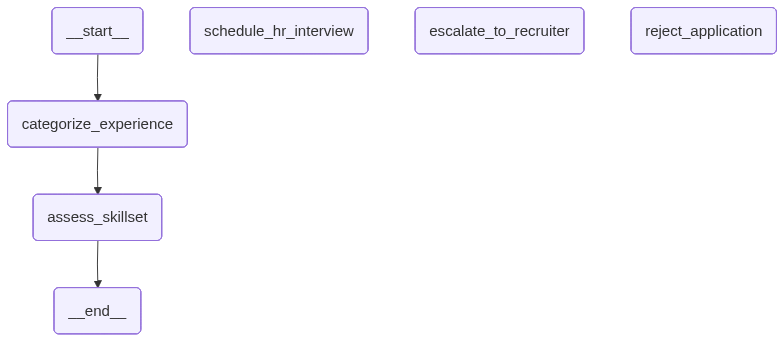

In [ ]:
# from IPython.display import Image, display
# display(
#     Image(
#         app.get_graph().draw_mermaid_png()
#     )
# )

In [ ]:
# def run_candidate_screening(application: str):
#   results = app.invoke({"application" : application})
#   return {
#       "experience_level" : results["experience_level"],
#       "skill_match" : results["skill_match"],
#       "response" : results["response"]
#   }

In [ ]:
# application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
# results = run_candidate_screening(application_text)
# print("\n\nComputed Results :")
# print(f"Application: {application_text}")
# print(f"Experience Level: {results['experience_level']}")
# print(f"Skill Match: {results['skill_match']}")
# print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : The candidate would be categorized as 'Senior-level' based on their 10 years of experience in software engineering.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: The candidate would be categorized as 'Senior-level' based on their 10 years of experience in software engineering.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.


In [ ]:
# application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
# results = run_candidate_screening(application_text)
# print("\n\nComputed Results :")
# print(f"Application: {application_text}")
# print(f"Experience Level: {results['experience_level']}")
# print(f"Skill Match: {results['skill_match']}")
# print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided, the candidate would be categorized as 'Entry-level'. With only 1 year of experience in software engineering, the candidate is still early in their career.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 1 year of experience in software engineering with expertise in JAVA
Experience Level: Based on the information provided, the candidate would be categorized as 'Entry-level'. With only 1 year of experience in software engineering, the candidate is still early in their career.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.


In [ ]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : To accurately categorize the candidate's level based on the provided application, we would need more detailed information such as the number of years of experience, the complexity of projects handled, leadership responsibilities, and specific achievements. However, based solely on the statement "I have experience in software engineering with expertise in Python," the candidate could potentially fall into any of these categories. 

- **Entry-level:** If the candidate is relatively new to the field, possibly with less than 2 years of experience, but has developed a strong expertise in Python through early job roles, internships, or academic projects.

- **Mid-level:** If the candidate has a few years (typically 2-5 years) of professional experience working on various software engineering projects and has developed a robust expertise in Python as part of more complex projects or in specialized roles.

- **Senior-level:*

In [ ]:
application_text = "I have 5 years of experience in software engineering with expertise in C++"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided, the candidate would be categorized as 'Mid-level'. With 5 years of experience in software engineering and expertise in C++, they have surpassed entry-level qualifications but have not yet reached senior-level experience, which typically starts around 7-10 years in the field.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 5 years of experience in software engineering with expertise in C++
Experience Level: Based on the information provided, the candidate would be categorized as 'Mid-level'. With 5 years of experience in software engineering and expertise in C++, they have surpassed entry-level qualifications but have not yet reached senior-level experience, which typically starts around 7-10 years in the field.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.
